In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from general_utils import timer

from config import RANDOM_SEED

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from collections import Counter, defaultdict

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import pickle

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [4]:
import torch
import pickle
from transformers import BertModel, BertTokenizer
from general_utils import timer
import os
import numpy as np
from bert_utils import load_model, load_tokenizer, batch_text_gen
import torch
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
torch.cuda.device_count()

2

In [6]:
torch.cuda.set_device(0)

In [7]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = False

In [8]:
def get_kw_bert_rep(kw_list,layer_map,bert_tokenizer,bert_model,bs=10):
    """
    """
    batch_count = 0
    for kw_batch in batch_text_gen(kw_list,batch_size = bs):
        print("Batch No : %s" %str(batch_count))
        tokenized_kw_batch, encoded_batch_ids = tokenize_bert_single_token(kw_batch,bert_tokenizer)
        batch_out = bert_model(input_ids=tokenized_kw_batch)
        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 
        
        for layer_ind in range(13):
            for t_id, token in enumerate(kw_batch):
                token_hidden_state = batch_hidden_states[layer_ind][t_id,:,:].cpu().detach().numpy()
                # index here to drop the pad tokens and only consider the actual word representation (if subwords then avg the subwords to get word representation) (PAD has token id of 0)
                token_hidden_state = combine_subwords(token_hidden_state,encoded_batch_ids[t_id])
                layer_map[token]["layer_%s"%str(layer_ind)] = token_hidden_state
        batch_count+=1 
        
def tokenize_bert_single_token(token_batch,tokenizer,debug_flag=False):
    """
    """
    encoded_batch = []
    for token in token_batch:
        encoded_token = tokenizer.encode(token,add_special_tokens=False,padding="max_length",max_length=10) # padding is longest because subwords exist in the vocab so the tokenizer splits a given word into subwords
        if debug_flag:
            print(token)
            print(tokenizer.convert_ids_to_tokens(encoded_token))
        encoded_batch.append(encoded_token)
    
    tokenized_batch = torch.LongTensor(encoded_batch)
    tokenized_tensor = tokenized_batch.to('cuda')
    return tokenized_tensor, encoded_batch

def compare_bert_rep_token(kw_topic_specific,kw_topic_indep,plot=True):
    """
    """
    bert_mod = load_model()
    bert_tok = load_tokenizer()
    
    bert_map = defaultdict(lambda :defaultdict())
    
    # topic specific keywords
    print("Getting bert representation for Topic Specific Keywords ... \n")
    batch_size = get_batch_size(kw_topic_specific)
    
    get_kw_bert_rep(kw_list=kw_topic_specific,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # topic indep keywords
    print("Getting bert representation for Topic Independent Keywords ... \n")
    batch_size = get_batch_size(kw_topic_indep)
    
    get_kw_bert_rep(kw_list=kw_topic_indep,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # cosin_sim
    cosine_sims_layer_map = defaultdict(list)
    pair_count=0
    for wp in itertools.product(kw_topic_indep,kw_topic_specific):
        for layer_id in range(13):
            cos_sim = cosine_similarity(bert_map[wp[0]]["layer_%s"%str(layer_id)],bert_map[wp[1]]["layer_%s"%str(layer_id)])
            cosine_sims_layer_map[layer_id].append(cos_sim)
        pair_count+=1
    
    print("No of Pairs : %s" %str(pair_count))
    
    # avg
    avg_scores = []
    for layer in sorted(cosine_sims_layer_map.keys()):
        avg_scores.append(np.mean(cosine_sims_layer_map[layer]))
    
    # plot
    if plot:
        fig,ax = plt.subplots(1,1,figsize=(10,8))
        ax.scatter(range(13),avg_scores,s=100)
        ax.set_xlabel("Bert Layers")
        ax.set_ylabel("Avg Cosine Similarity")
        ax.set_xticks(range(-1,13,1))
        ax.set_xlim(-1,13)
        ax.set_ylim(0.0,1.0)
        sns.regplot(x=[i for i in range(13)], y=avg_scores,ax=ax,color="cornflowerblue")
        plt.title("Average Cosine Similarity between Topic Independant Keywords and Topic Specific Keywords\n for Representations from different Layers of BERT")
        plt.grid(True, linestyle='--')
        plt.tight_layout()
        plt.show()
    return bert_map,avg_scores
        
def get_batch_size(kw_list,ratio=10):
    """
    """
    batch_size = int(len(kw_list)/ratio)
    
    if len(kw_list) <=25:
        batch_size = len(kw_list)
    
    return batch_size

def combine_subwords(hidden_state,token_ids):
    """
    hidden_state_shape = (maxlength_padding,768)
    
    choose token_ids that are not 0
    
    """
    subword_arrs = []
    for t_i,t in enumerate(token_ids):
        if t != 0:
            subword_arrs.append(hidden_state[t_i,:])
    
    return np.mean(subword_arrs,axis=0).reshape(1,-1)

@timer
def get_all_clustered_docs(keywords,clusters,doc_2_cluster_map,sample_df,partisan_score=0):
    """
    """
    relv_docs_cluster_map = defaultdict(lambda : defaultdict(list))
    keyword_index_cluster_map = defaultdict(lambda : defaultdict(list))
    total_docs_per_cluser = defaultdict(lambda : defaultdict(int))
    for c in clusters:
        print("\nCluster : %s" %str(c))
        docs_indexes = doc_2_cluster_map[c]
        texts = sample_df["all_text"].iloc[docs_indexes].tolist()
        partisan_scores = sample_df["binary_ps"].iloc[docs_indexes].tolist()
        for k in keywords:
            print("Keyword : %s" %str(k))
            for ind_t,t in enumerate(texts):
                if k in t.lower() and partisan_scores[ind_t]==partisan_score:
                    for ind,w in enumerate(word_tokenize(t.lower())):
                        if  w == k or k in w:
                            if ind <= 500:
                                keyword_index_cluster_map[k][c].append(ind)
                                relv_docs_cluster_map[k][c].append(t)
        
            total_docs_per_cluser[k][c] = len(relv_docs_cluster_map[k][c])
    
    print(total_docs_per_cluser)
    
    return relv_docs_cluster_map, keyword_index_cluster_map
        
def batch_text_gen_ind(text_list,index_list,batch_size=2):
    """
    """
    for ndx in range(0,len(text_list),batch_size):
        yield (text_list[ndx:min(ndx+batch_size,len(text_list))], index_list[ndx:min(ndx+batch_size,len(text_list))])

def tokenize_for_bert(text_batch,tokenizer):
    """
    """
    tokenized_tensor = torch.LongTensor([tokenizer.encode(text,
                                                          truncation=True,
                                                          padding="max_length",
                                                          max_length=500, 
                                                          add_special_tokens=False)  # Add [CLS] and [SEP],) 
                                                          for text in text_batch])
    tokenized_tensor = tokenized_tensor.to('cuda')
    return tokenized_tensor


@timer
def get_embeddings(keywords,relv_docs_cluster_map,keyword_index_cluster_map):
    """
    """
    bert_tokenizer = load_tokenizer()
    bert_model = load_model()
    layer_keyword_cluster_map = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
    
    for keyword in keywords:
        print("\nKeyword : %s" %keyword)
        for cluster in relv_docs_cluster_map[keyword].keys():
            print("Cluster : %s" %str(cluster))
            cluster_docs = relv_docs_cluster_map[keyword][cluster]
            if len(cluster_docs) > 0:
                keyword_indices = keyword_index_cluster_map[keyword][cluster]
                for cluster_doc_batch, keyword_indices_batch in batch_text_gen_ind(cluster_docs,keyword_indices,batch_size=2):
                    try:
                        tokenized_batch_text = tokenize_for_bert(text_batch=cluster_doc_batch,tokenizer=bert_tokenizer)
                        batch_out = bert_model(input_ids=tokenized_batch_text)
                        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 

                        for layer in range(13):
                            temp_reps = []
                            for ind,k_ind in enumerate(keyword_indices_batch):
                                temp_reps.append(batch_hidden_states[layer][ind,k_ind,:].cpu().detach().numpy())
                            layer_keyword_cluster_map[keyword][cluster][layer]+=temp_reps
                
                    except Exception as e:
                        print("Error Raised : \n")
                        print(e)
                    

    return layer_keyword_cluster_map


def take_mean(layer_keyword_cluster_map):
    """
    """
    for keyword in layer_keyword_cluster_map.keys():
        for cluster in layer_keyword_cluster_map[keyword].keys():
            for layer in layer_keyword_cluster_map[keyword][cluster].keys():
                list_batch_outs = layer_keyword_cluster_map[keyword][cluster][layer]
                layer_keyword_cluster_map[keyword][cluster][layer] = np.mean(list_batch_outs,axis=0).reshape(1,-1)

def plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword,avg_rp_word_sim):
    """
    """
    clusters = layer_keyword_cluster_map[keyword].keys()
    
    cluster_pairs = list(itertools.combinations(clusters,2))
    fig,ax = plt.subplots(1,1,figsize=(30,12))
    colors_map = sns.color_palette("tab20", n_colors=13)
    
    for layer in range(1,13,1):
        
        cosine_sims = []
        x = [i for i in range(len(cluster_pairs))]
        for cp in cluster_pairs:
            cosine_sim = cosine_similarity(layer_keyword_cluster_map[keyword][cp[0]][layer],layer_keyword_cluster_map[keyword][cp[1]][layer])
            cosine_sims.append(cosine_sim/avg_rp_word_sim[layer])
        
        ax.scatter(x,cosine_sims,color=colors_map[layer],s=50,label="layer_%s"%str(layer))
#         sns.regplot(x=x, y=cosine_sims,ax=ax,color=colors_map[layer])
    
    ax.set_xlabel("Cluster-Pairs")
    ax.set_ylabel("Cosine Similarity")
#     ax.set_ylim(0.0,1.0)
#     ax.set_xticks([i for i in range(len(cluster_pairs))])
#     ax.set_xticklabels([ str(cp) for cp in cluster_pairs],rotation = 90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Average Cosine Similarity between Bert Representations of **** %s **** for each layer"%str(keyword))
    plt.grid(False, linestyle='--')
    plt.tight_layout()
    plt.show()
    pass

def plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword,avg_rp_word_sim):
    """
    """
    clusters = layer_keyword_cluster_map[keyword].keys()
    
    cluster_pairs = list(itertools.combinations(clusters,2))
    fig,ax = plt.subplots(1,1,figsize=(10,8))
    colors_map = sns.color_palette("tab20", n_colors=13)
    
    for layer in range(1,13,1):
        
        cosine_sims = []
        x = [i for i in range(len(cluster_pairs))]
        for cp in cluster_pairs:
            cosine_sim = cosine_similarity(layer_keyword_cluster_map[keyword][cp[0]][layer],layer_keyword_cluster_map[keyword][cp[1]][layer])
            cosine_sims.append(cosine_sim/avg_rp_word_sim[layer])
    
        avg_cosine_sim = np.mean(cosine_sims)
        
        ax.scatter(layer,avg_cosine_sim,color=colors_map[layer],s=100,label="layer_%s"%str(layer))
    
    ax.set_xlabel("Bert Layer Representations")
    ax.set_ylabel("Average Cosine Similarity of a Keyword Across all Cluster Pairs")
#     ax.set_ylim(0.0,1.0)
    plt.legend()
    plt.title("Average Cosine Similarity of a Keyword Across all Cluster Pairs vs Bert Representations across all layers")
    plt.grid(False, linestyle='--')
    plt.tight_layout()
    plt.show()
    

def plot_all_keywords_avg_cos_sim_all_layers(layer_keyword_cluster_map):
    """
    """
    
    for keyword in layer_keyword_cluster_map.keys():
        
        clusters = layer_keyword_cluster_map[keyword].keys()
    
        cluster_pairs = list(itertools.combinations(clusters,2))
        
        

In [10]:
def load_pkl_file(file_path):
    """
    """
    article_dict = pickle.load(open(file_path,"rb"))
    articles = []
    for article in article_dict.keys():
        articles.append(article_dict[article])
    
    print("Number of Articles : %s"%str(len(articles)))
    articles_df = pd.DataFrame(articles)
    print("Shape Before Processing : %s" %str(articles_df.shape))
    #drop columns
    articles_df.drop(columns=["article_id",
                              "url",
                              "source",
                              "tweet_id",
                              "tweet_text",
                              "kws_label",
                              "cls_label",
                              "tweet_screen_name",
                              "tweet_created_at"],inplace=True)
    #reset index
    articles_df.reset_index(inplace=True,drop=True)
    #drop partisan of 0.0
    articles_df = articles_df.loc[articles_df["source_partisan_score"] != 0.0]
    articles_df["binary_ps"] = articles_df["source_partisan_score"].apply(lambda x: 1 if x>0 else 0)
    print("Shape after dropping Neutral Articles : %s" %str(articles_df.shape))
    print(articles_df.columns)
    return articles_df

In [11]:
path =  "../labeled_political_articles.pkl"

articles_df = load_pkl_file(path)

sampled_df = sample_data(df=articles_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

Number of Articles : 219824
Shape Before Processing : (219824, 12)
Shape after dropping Neutral Articles : (170405, 4)
Index(['title', 'text', 'source_partisan_score', 'binary_ps'], dtype='object')

Finished running 'sample_data' in 0.0007 mins

Sampled Size: 100000


In [12]:
sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])
vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)
# reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)
reduced_vectors = vectors
clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=100,clus_type="kmeans")
cluster_sizes = get_cluster_sizes(cluster_clf)
cluster_pairs = get_cluster_pairs(num_clusters=100)
print(len(cluster_pairs))

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3277 mins

vocab_size : 15008

Finished running 'tfidf_vectorization' in 0.1718 mins


Running KMEANS Clustering with k=100

Finished running 'run_clustering' in 0.0925 mins


Finished running 'get_cluster_sizes' in 0.0002 mins


Number of Cluster Pairs : 4950

Finished running 'get_cluster_pairs' in 0.0000 mins

4950


In [13]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0004 mins



In [14]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=200,
                                        max_size=10000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0151 mins

Filtered CLustered Pairs : 666


In [15]:
clusters = []
for cp in filtered_cluster_pairs:
    clusters.append(cp[0])
    clusters.append(cp[1])

print(set(clusters))
print(len(set(clusters)))
clusters = list(set(clusters))

{0, 2, 3, 6, 13, 16, 17, 18, 20, 21, 25, 27, 28, 29, 33, 36, 43, 44, 45, 47, 53, 55, 57, 59, 60, 62, 67, 71, 75, 78, 81, 83, 84, 86, 87, 93, 96}
37


In [16]:
# Keywords Professor Identified:
conservative_keywords = ["democrats", "media","socialist"]
liberal_keywords = ["donald", "republicans", "progressive"]

# overlapping_conservative_keywords:
#     pick top 50 from file
    
# overlapping_liberal_keywords:
#     pick top 50 from file

In [67]:
from urllib.request import Request, urlopen
import random


url="https://svnweb.freebsd.org/csrg/share/dict/words?revision=61569&view=co"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

web_byte = urlopen(req).read()

webpage = web_byte.decode('utf-8')
words = webpage.split("\n")
print(len(words))

25488


In [68]:
rl1 = [random.choice(words).strip() for i in range(100)]
rl2 = [random.choice(words).strip() for i in range(100)]

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
No of Pairs : 10000


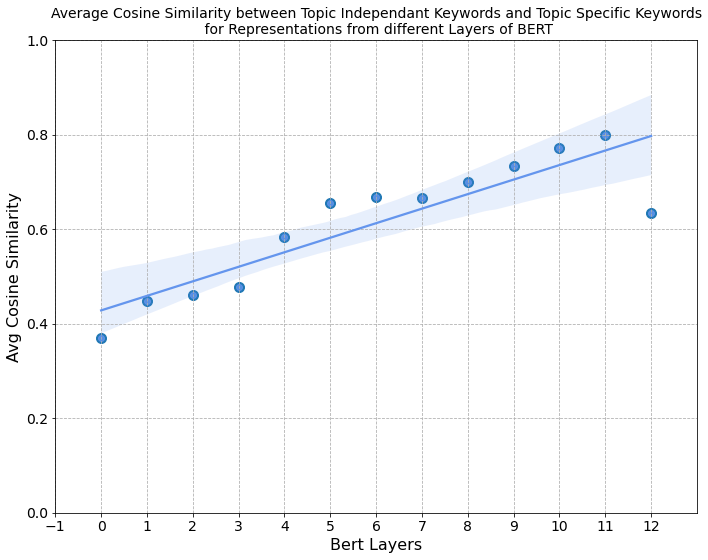

In [79]:
# have to computer pair wise cosine similarity between 2 of these lists, avg them then divide the rest in take_mean
layer_map,avg_scores_rp = compare_bert_rep_token(kw_topic_specific=rl1,
                                   kw_topic_indep=rl2,plot=False)

In [80]:
avg_rp_score = np.array(avg_scores_rp)

In [81]:
avg_rp_score.shape

(13,)

In [17]:
# To-DO:
# * for each keyword , get the cluster-stance documents that contain it, repeat for each cluster
# * you will get a dict of cluster-docs for each keyword
# * from this get bert embeddings for each cluster by averaging the corresponding word embedding for the keyword
# * for every cluster pair:
#     * calculate cosine sim between the averaged vectors
#     * repeat for each bert layer
# * create a map from layer -> list of cosine similarities between the cluster pairs
# * plot for each layer
# * plot avg cosine sim vs layer for each keyword
# * plot avg cosine sim for all conservative keywords vs layer
# * plot avg cosine sim for all liberal keywords vs layer

## Conservative Keywords Results :

In [127]:
relv_docs_cluster_map, keyword_index_cluster_map = get_all_clustered_docs(keywords=conservative_keywords,
                                                                          clusters=clusters,
                                                                          doc_2_cluster_map=doc_2_cluster_map,
                                                                          sample_df=sampled_df, partisan_score=1)


Cluster : 0
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 2
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 3
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 6
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 13
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 16
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 17
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 18
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 20
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 21
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 25
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 27
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 28
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 29
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 33
Keyword : 

In [128]:
layer_keyword_cluster_map = get_embeddings(keywords=conservative_keywords,
                                           relv_docs_cluster_map=relv_docs_cluster_map,
                                           keyword_index_cluster_map=keyword_index_cluster_map)


Keyword : democrats
Cluster : 0
Cluster : 2
Cluster : 3
Cluster : 6
Cluster : 13
Cluster : 16
Cluster : 17
Cluster : 18
Cluster : 20
Cluster : 21
Cluster : 25
Cluster : 27
Cluster : 28
Cluster : 29
Cluster : 33
Cluster : 36
Cluster : 43
Cluster : 44
Cluster : 45
Cluster : 47
Cluster : 53
Cluster : 55
Cluster : 57
Cluster : 59
Cluster : 60
Cluster : 62
Cluster : 67
Cluster : 71
Cluster : 75
Cluster : 78
Cluster : 81
Cluster : 83
Cluster : 84
Cluster : 86
Cluster : 87
Cluster : 93
Cluster : 96

Keyword : media
Cluster : 0
Cluster : 2
Cluster : 3
Cluster : 6
Cluster : 13
Cluster : 16
Cluster : 17
Cluster : 18
Cluster : 20
Cluster : 21
Cluster : 25
Cluster : 27
Cluster : 28
Cluster : 29
Cluster : 33
Cluster : 36
Cluster : 43
Cluster : 44
Cluster : 45
Cluster : 47
Cluster : 53
Cluster : 55
Cluster : 57
Cluster : 59
Cluster : 60
Cluster : 62
Cluster : 67
Cluster : 71
Cluster : 75
Cluster : 78
Cluster : 81
Cluster : 83
Cluster : 84
Cluster : 86
Cluster : 87
Cluster : 93
Cluster : 96

Keyword

In [129]:
take_mean(layer_keyword_cluster_map)

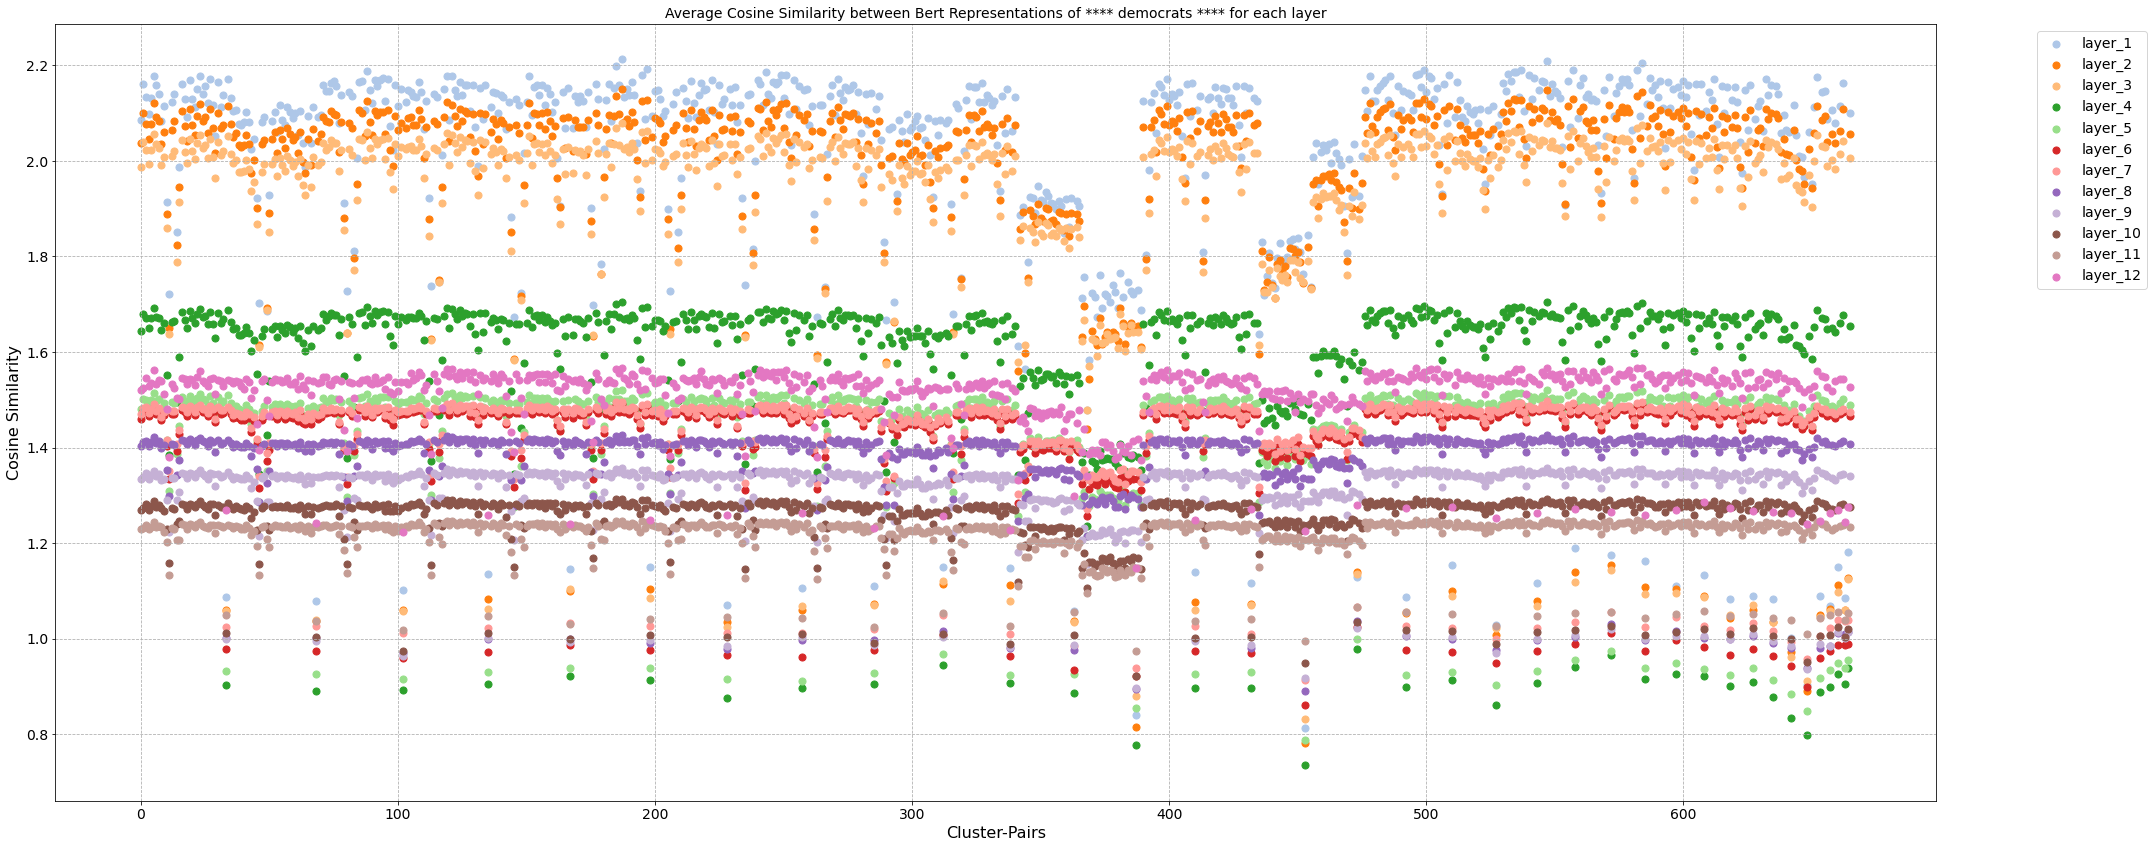

In [130]:
plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="democrats",avg_rp_word_sim=avg_rp_score)

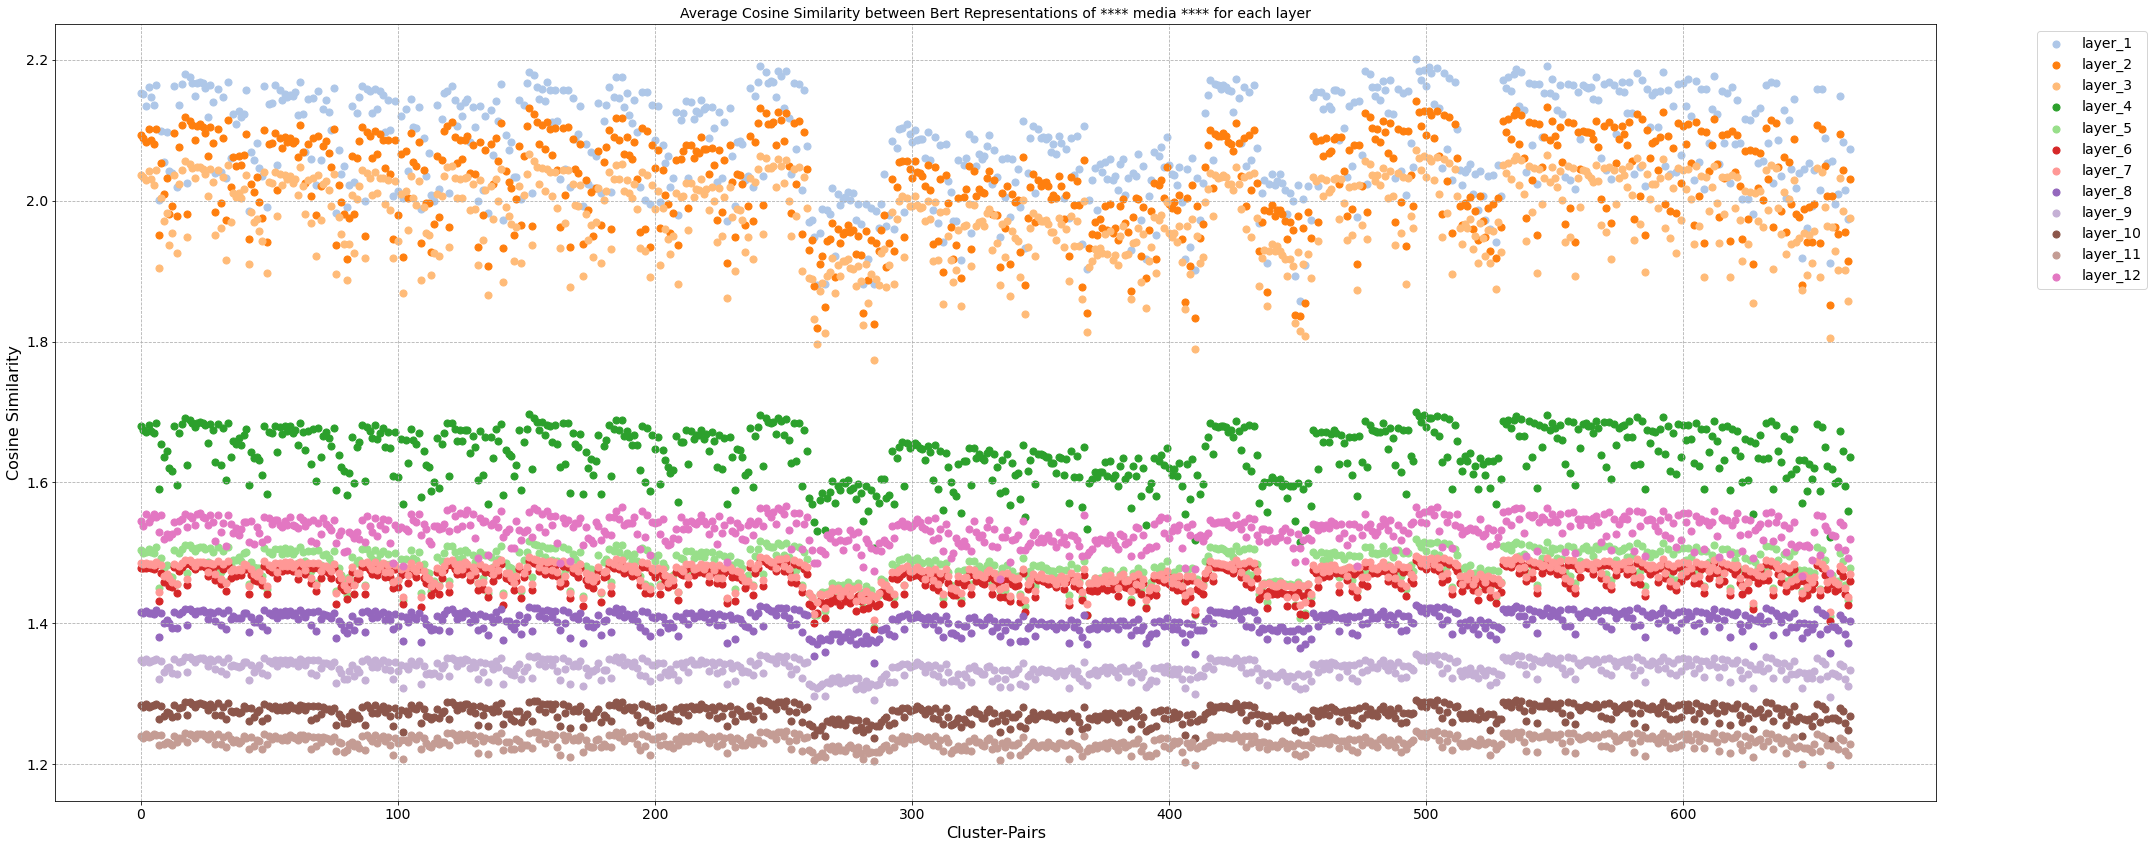

In [131]:
plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="media",avg_rp_word_sim=avg_rp_score)

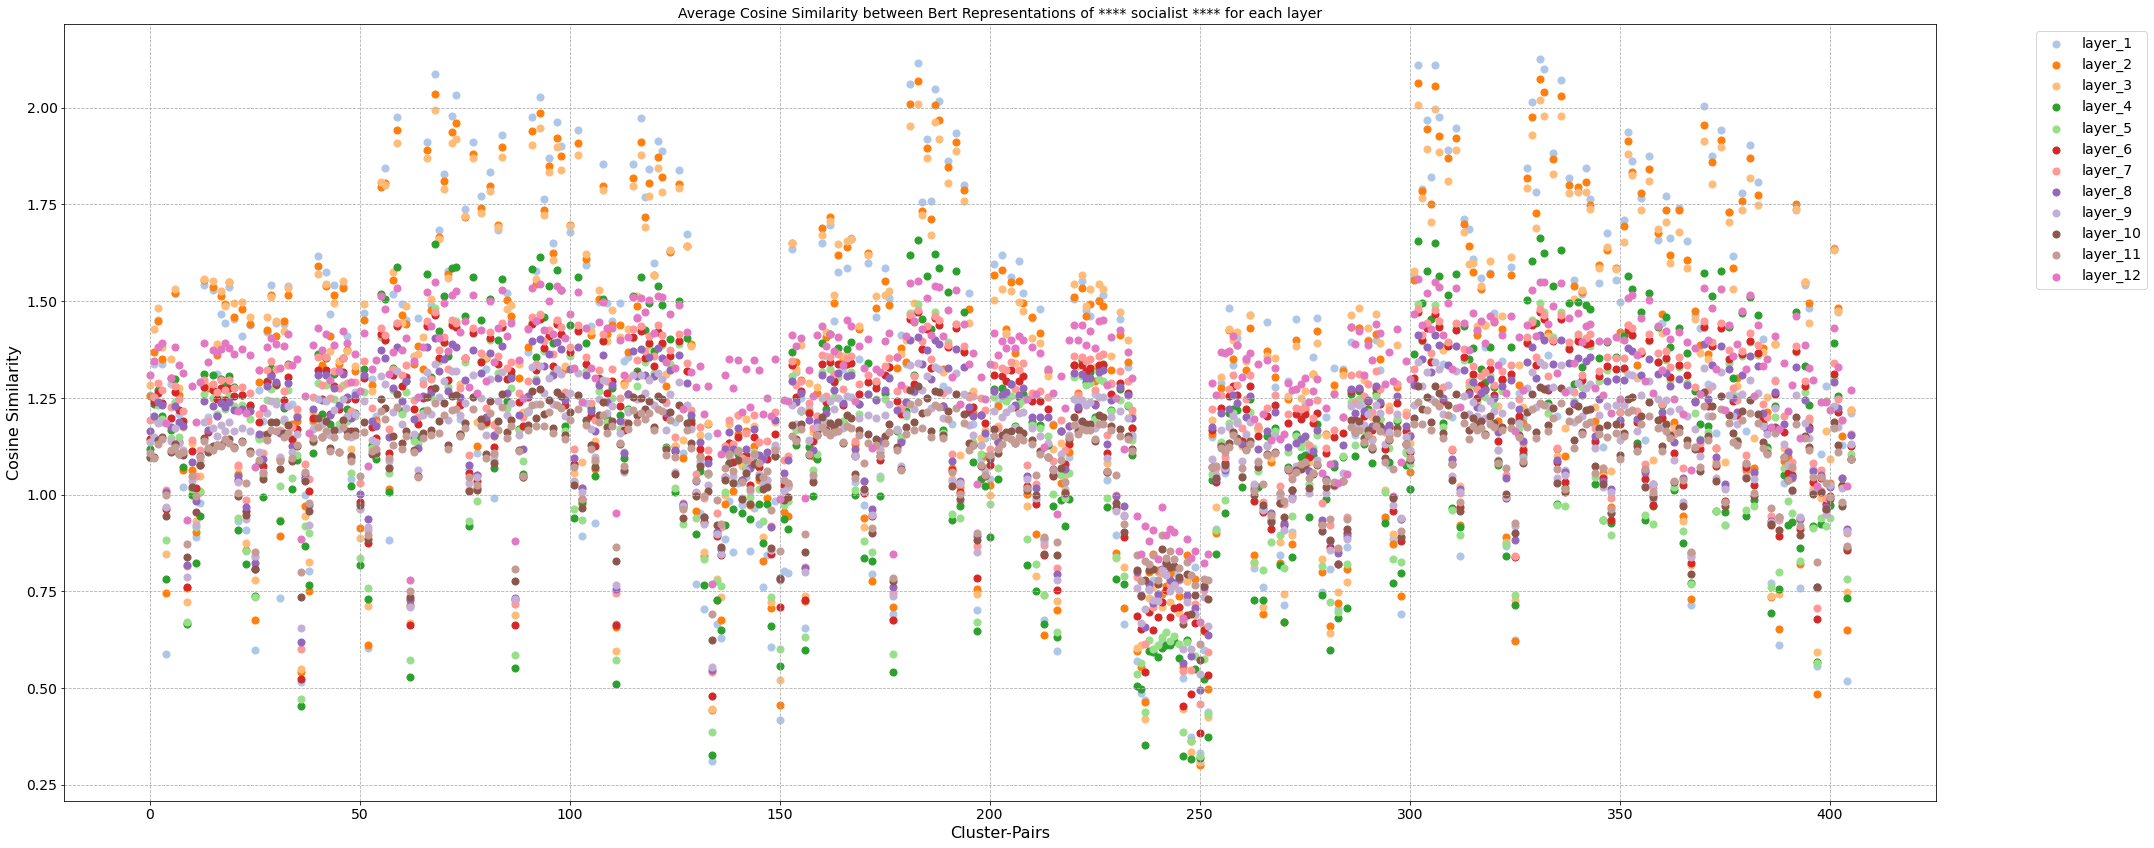

In [132]:
plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="socialist", avg_rp_word_sim=avg_rp_score)

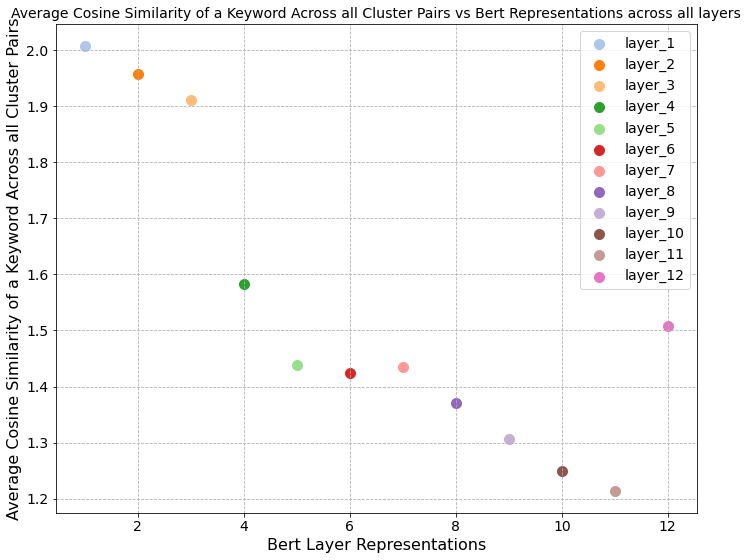

In [133]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="democrats",avg_rp_word_sim=avg_rp_score)

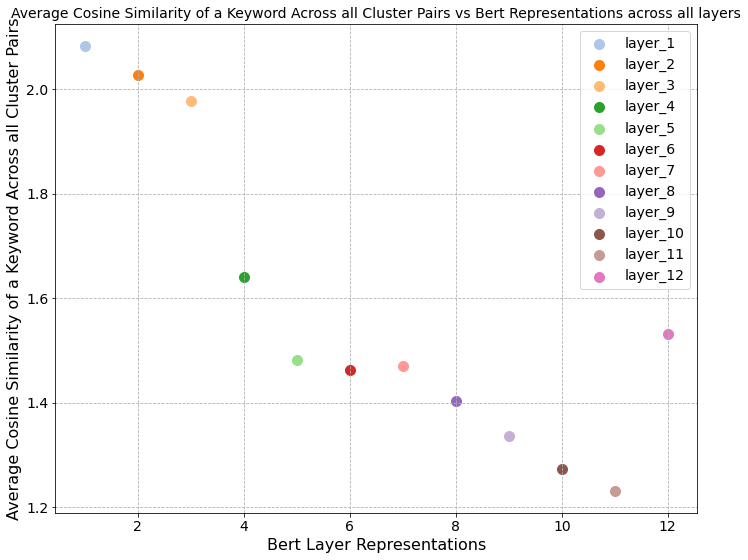

In [134]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="media",avg_rp_word_sim=avg_rp_score)

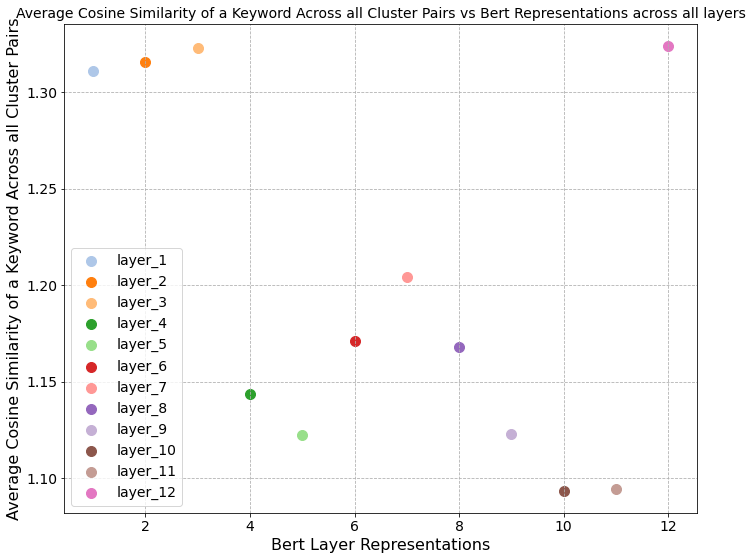

In [135]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="socialist",avg_rp_word_sim=avg_rp_score)

## Liberal Keyword Results :

In [103]:
relv_docs_cluster_map, keyword_index_cluster_map = get_all_clustered_docs(keywords=liberal_keywords,
                                                                          clusters=clusters,
                                                                          doc_2_cluster_map=doc_2_cluster_map,
                                                                          sample_df=sampled_df, partisan_score=0)


Cluster : 0
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 2
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 3
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 6
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 13
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 16
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 17
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 18
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 20
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 21
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 25
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 27
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 28
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 29
Keyword : donal

In [104]:
layer_keyword_cluster_map = get_embeddings(keywords=liberal_keywords,
                                           relv_docs_cluster_map=relv_docs_cluster_map,
                                           keyword_index_cluster_map=keyword_index_cluster_map)


Keyword : donald
Cluster : 0
Cluster : 2
Cluster : 3
Cluster : 6
Cluster : 13
Cluster : 16
Cluster : 17
Cluster : 18
Cluster : 20
Cluster : 21
Cluster : 25
Cluster : 27
Cluster : 28
Cluster : 29
Cluster : 33
Cluster : 36
Cluster : 43
Cluster : 44
Cluster : 45
Cluster : 47
Cluster : 53
Cluster : 55
Cluster : 57
Cluster : 59
Cluster : 60
Cluster : 62
Cluster : 67
Cluster : 71
Cluster : 75
Cluster : 78
Cluster : 81
Cluster : 83
Cluster : 84
Cluster : 86
Cluster : 87
Cluster : 93
Cluster : 96

Keyword : republicans
Cluster : 0
Cluster : 2
Cluster : 3
Cluster : 6
Cluster : 13
Cluster : 16
Cluster : 17
Cluster : 18
Cluster : 20
Cluster : 21
Cluster : 25
Cluster : 27
Cluster : 28
Cluster : 29
Cluster : 33
Cluster : 36
Cluster : 43
Cluster : 44
Cluster : 45
Cluster : 47
Cluster : 53
Cluster : 55
Cluster : 57
Cluster : 59
Cluster : 60
Cluster : 62
Cluster : 67
Cluster : 71
Cluster : 75
Cluster : 78
Cluster : 81
Cluster : 83
Cluster : 84
Cluster : 86
Cluster : 87
Cluster : 93
Cluster : 96

Keyw

In [105]:
take_mean(layer_keyword_cluster_map)

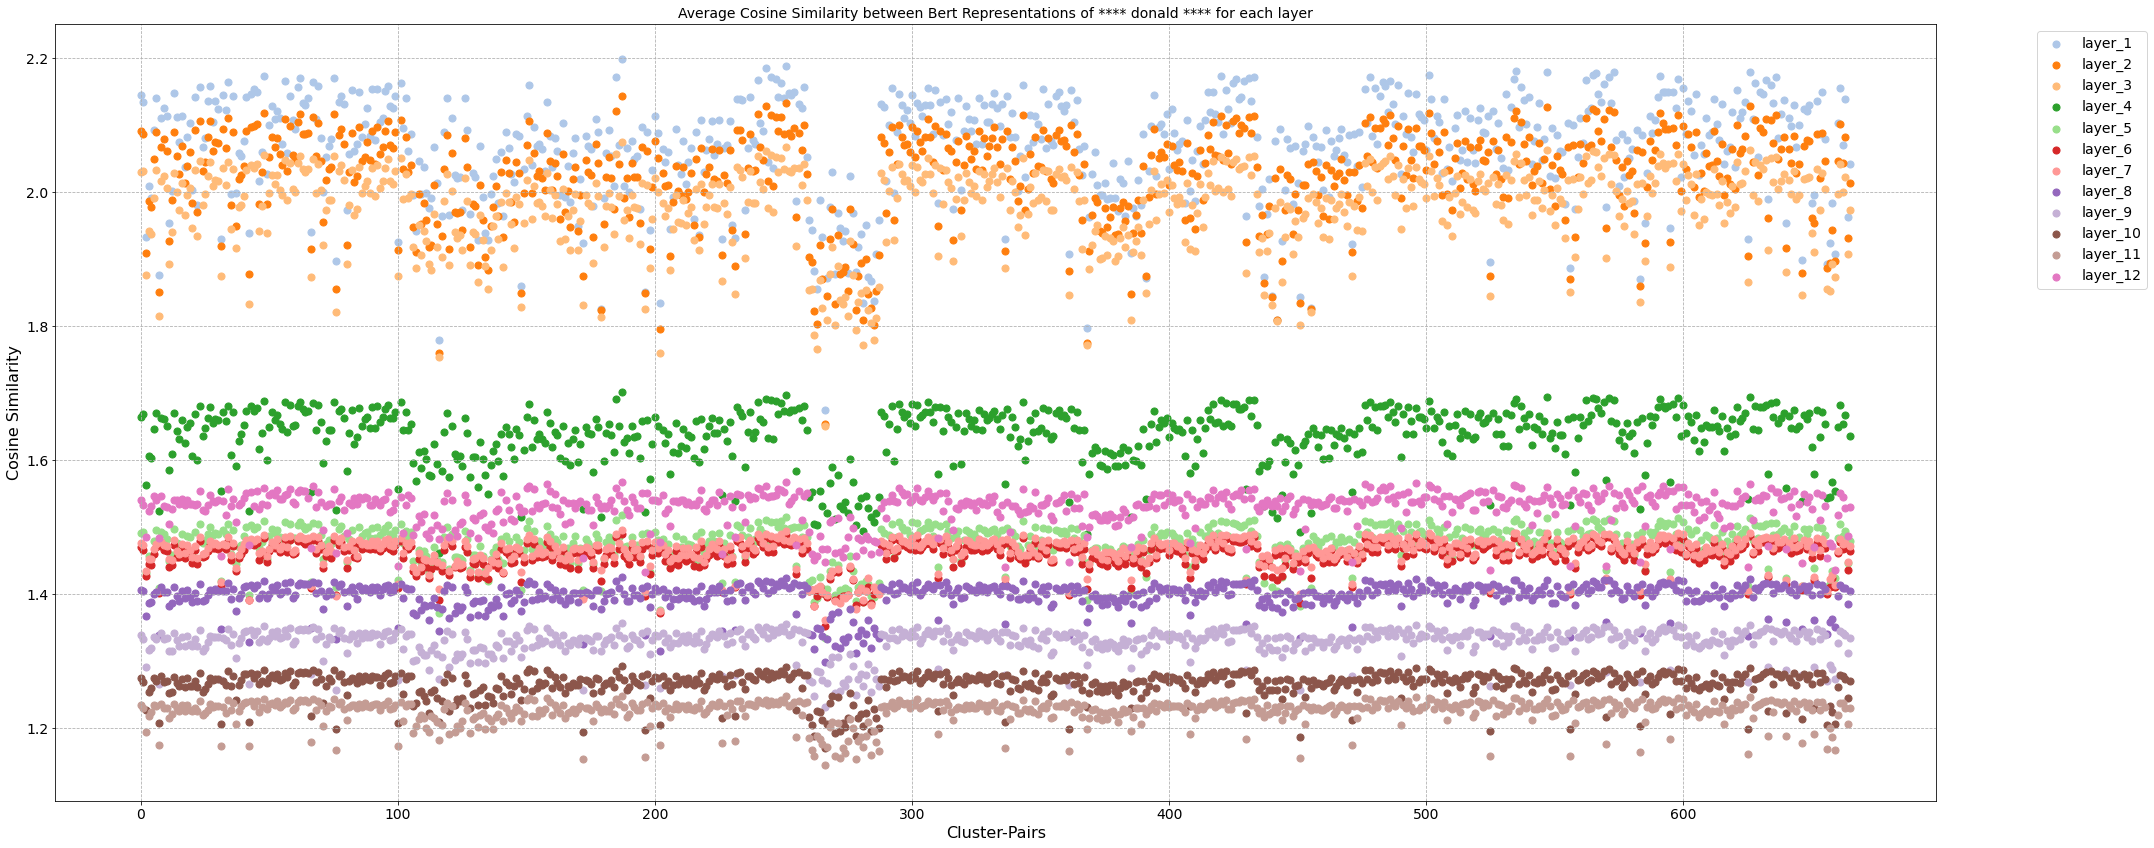

In [121]:
plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="donald",avg_rp_word_sim=avg_rp_score)

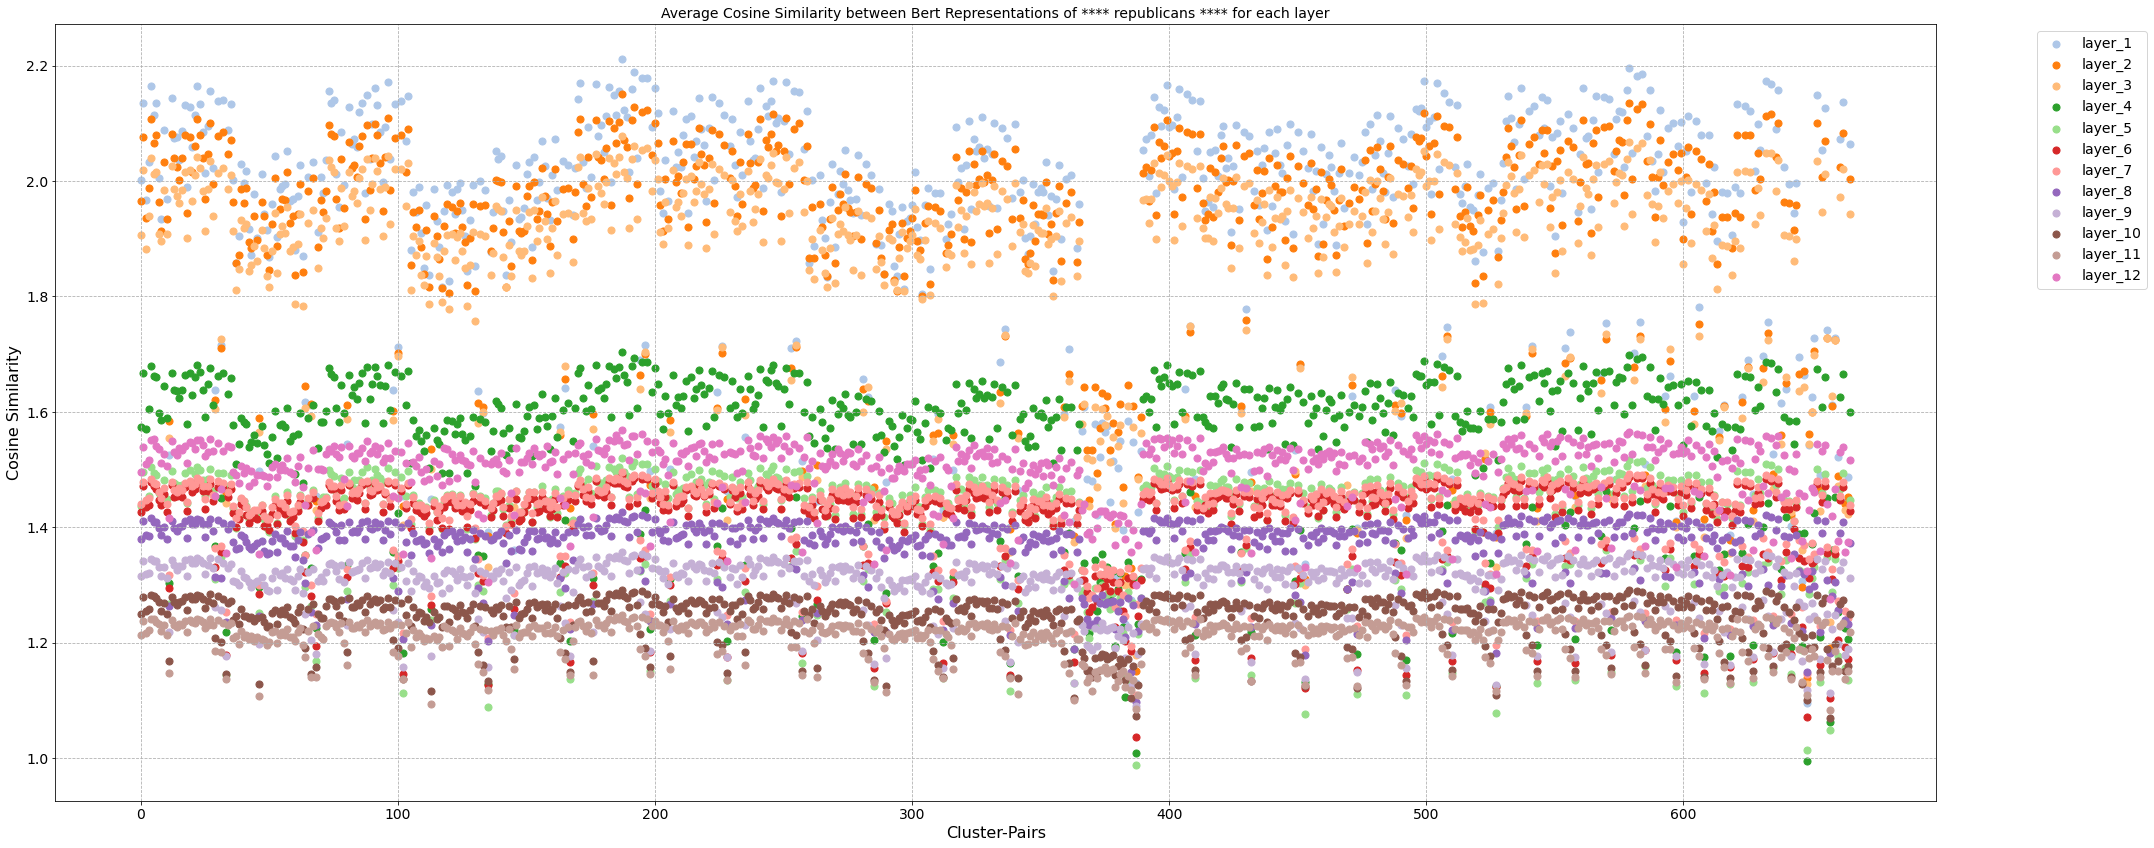

In [122]:
plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="republicans",avg_rp_word_sim=avg_rp_score)

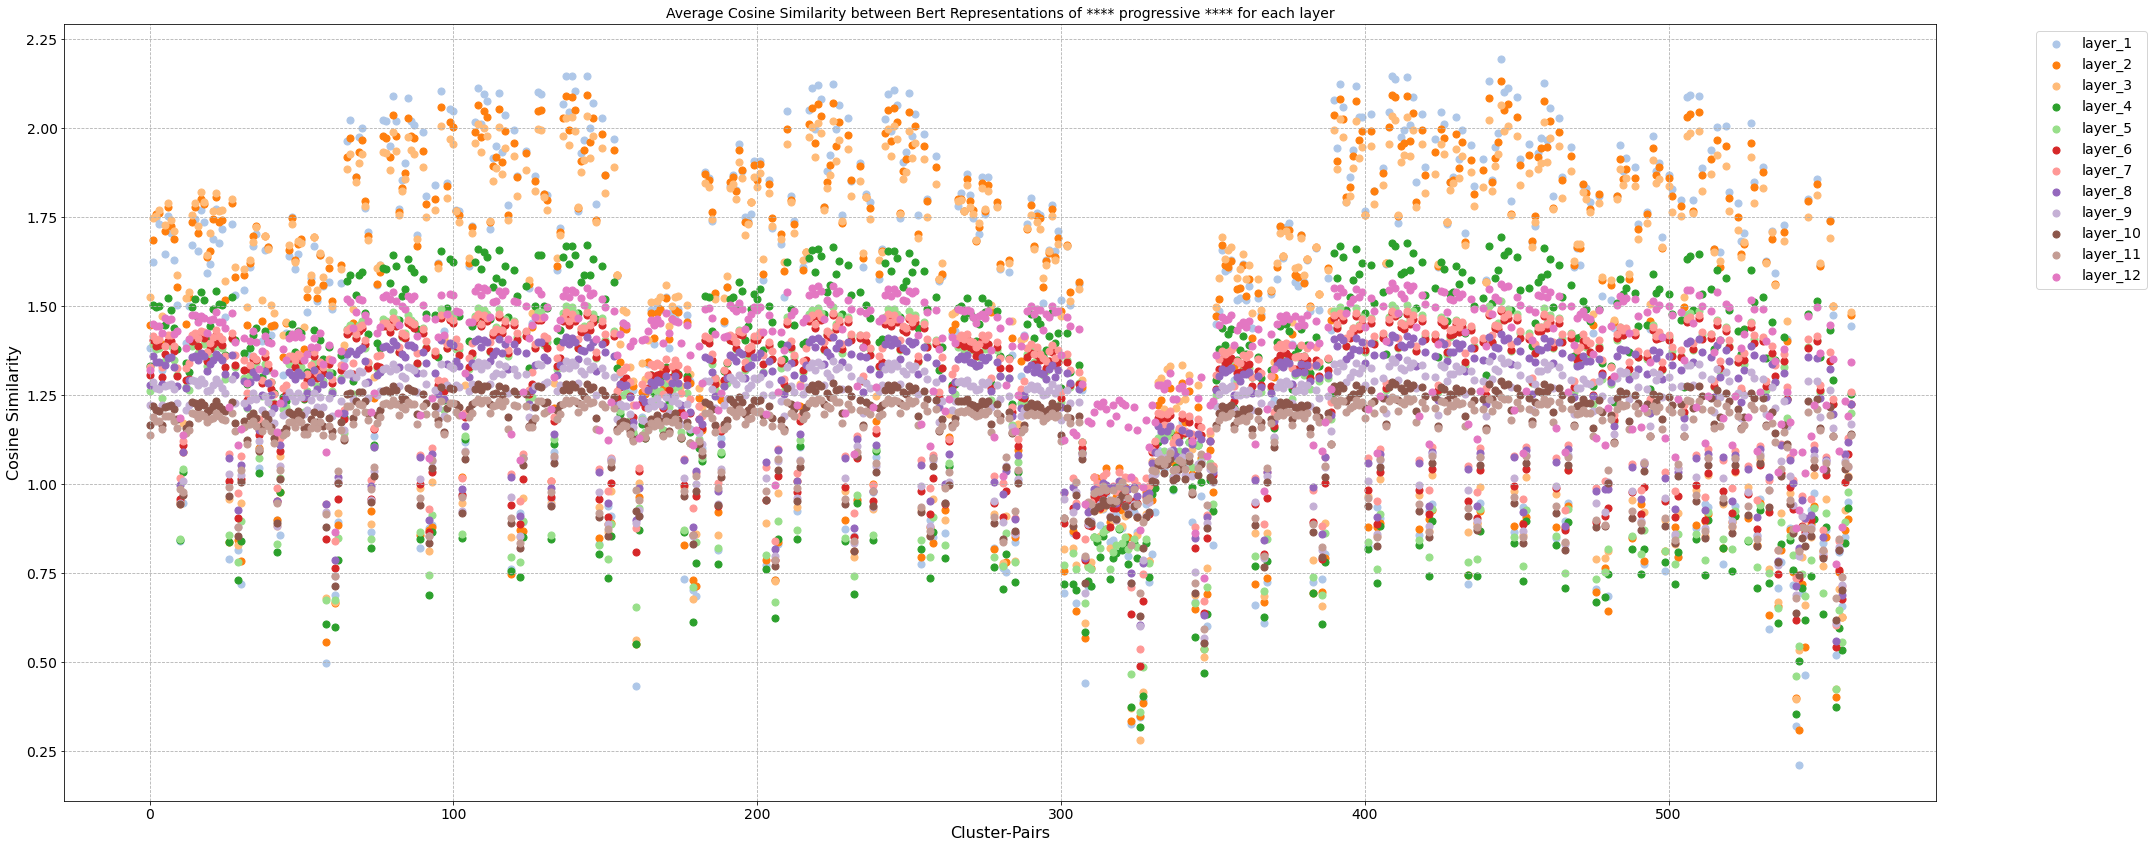

In [123]:
plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="progressive", avg_rp_word_sim=avg_rp_score)

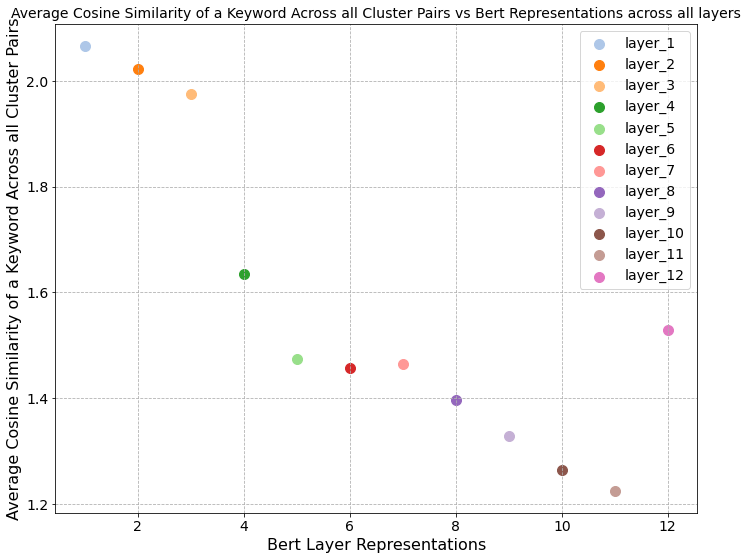

In [124]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="donald",avg_rp_word_sim=avg_rp_score)

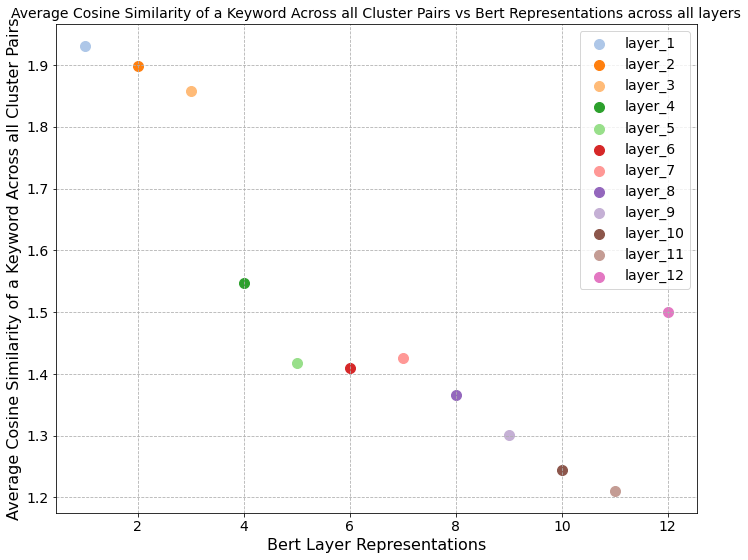

In [125]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="republicans",avg_rp_word_sim=avg_rp_score)

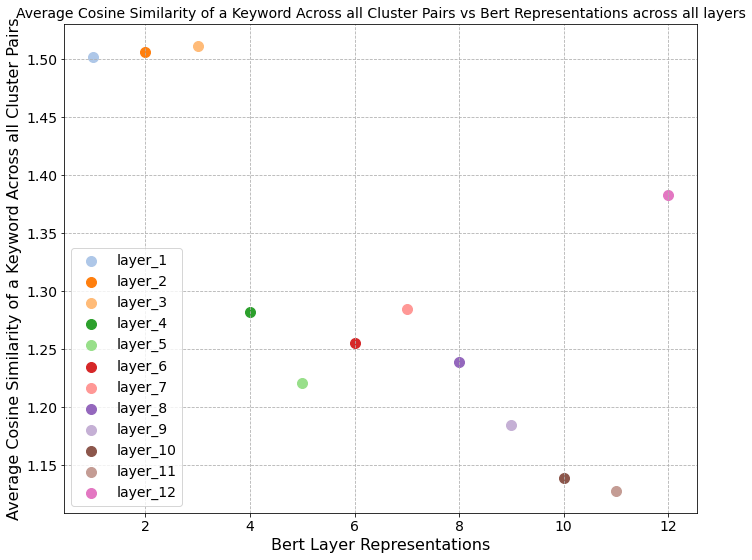

In [126]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="progressive", avg_rp_word_sim=avg_rp_score)

## Rep Var Analysis

In [17]:
tokenizer = load_tokenizer()

In [11]:
tokenize_bert_single_token(token_batch=["socialist"],tokenizer=tokenizer,debug_flag=True)

socialist
['socialist', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


(tensor([[6102,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
        device='cuda:0'),
 [[6102, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
tokenize_bert_single_token(token_batch=["progressive"],tokenizer=tokenizer,debug_flag=True)

progressive
['progressive', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


(tensor([[6555,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
        device='cuda:0'),
 [[6555, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
type(tokenizer.vocab)

collections.OrderedDict

In [19]:
"socialist" in tokenizer.vocab

True

In [20]:
"progressive" in tokenizer.vocab

True